<a href="https://colab.research.google.com/github/gantenandini/AI_ML/blob/main/Halohues_Studios_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17018, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 17018 (delta 120), reused 122 (delta 67), pack-reused 16805 (from 1)
Receiving objects: 100% (17018/17018), 15.74 MiB | 23.03 MiB/s, done.
Resolving deltas: 100% (11653/11653), done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:

!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 33.9 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python


In [ ]:
import torch
print(torch.__version__)n
print(torch.cuda.is_available())


2.4.1+cu121
True


In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q mtcnn
!pip install -q pillow
!pip install -q matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00


In [ ]:
!pip install -q opencv-python

In [7]:
!pip install retina-face

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-23 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


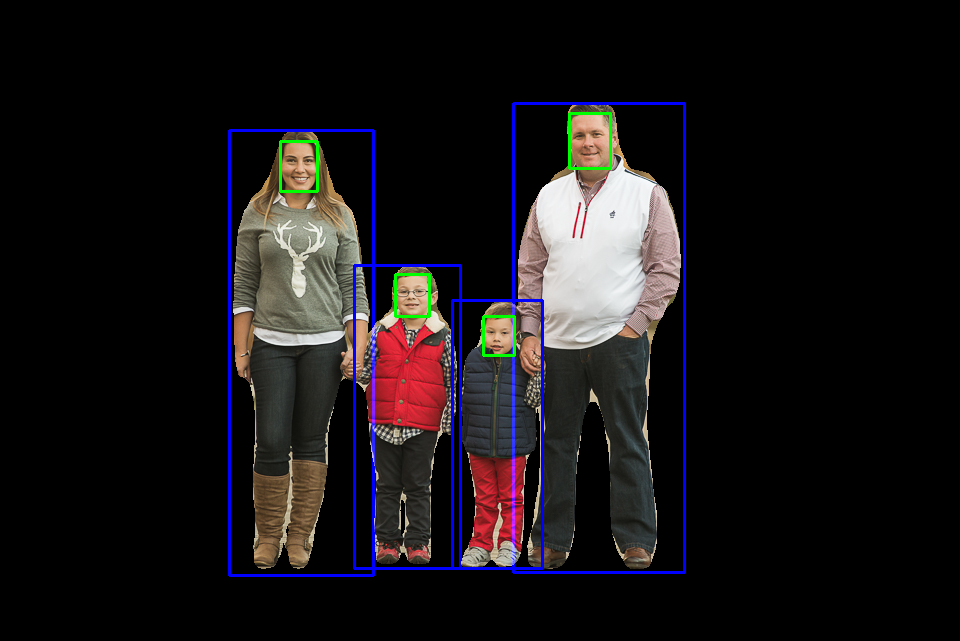

Processed image saved as 'processed_image_with_blackbackground_bg.png'


In [17]:
import cv2
import torch
import numpy as np
import torchvision.transforms as T
from torchvision import models
from retinaface import RetinaFace  # Importing RetinaFace
from google.colab.patches import cv2_imshow

# Loading pre-trained YOLOv5 model for human detection
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Loading Mask R-CNN for segmentation
mask_rcnn = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

# Function to detect humans in an image using YOLOv5
def detect_humans(img):
    try:
        results = model(img)
        detections = results.pandas().xyxy[0]
        humans = detections[detections['class'] == 0]
        return humans
    except Exception as e:
        print(f"Error during human detection: {e}")
        return None

# Function to detect faces using RetinaFace
def detect_faces_retinaface(human_roi):
    try:
        # Perform face detection with RetinaFace
        faces = RetinaFace.detect_faces(human_roi)

        face_boxes = []
        if faces:
            for face in faces.values():
                facial_area = face['facial_area']
                x1, y1, x2, y2 = facial_area
                face_boxes.append((x1, y1, x2 - x1, y2 - y1))

        return face_boxes
    except Exception as e:
        print(f"Error during face detection with RetinaFace: {e}")
        return []

# Function to apply Mask R-CNN segmentation and remove background
def apply_mask_rcnn_segmentation(image, human_bbox, bg_color=(0, 0, 0)):
    x1, y1, x2, y2 = human_bbox
    human_roi = image[y1:y2, x1:x2]

    # Convert the image to a tensor for Mask R-CNN
    transform = T.Compose([T.ToTensor()])
    human_roi_tensor = transform(human_roi).unsqueeze(0)

    # Get the Mask R-CNN results
    with torch.no_grad():
        output = mask_rcnn(human_roi_tensor)[0]

    # Extract the segmentation mask for the person class (COCO class 1)
    masks = output['masks'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    person_mask = np.zeros_like(masks[0, 0], dtype=np.uint8)

    for i, score in enumerate(scores):
        if score > 0.5 and output['labels'][i].item() == 1:
            person_mask = np.maximum(person_mask, masks[i, 0])

    # Resize mask to original human ROI size
    mask_resized = cv2.resize(person_mask, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)


    output_image = np.zeros_like(human_roi)
    output_image[mask_resized > 0.5] = human_roi[mask_resized > 0.5]

    # Create a mask to ensure we keep only the segmented human and black out the rest inside bounding box
    full_output = np.full_like(image, bg_color)
    full_output[y1:y2, x1:x2][mask_resized > 0.5] = image[y1:y2, x1:x2][mask_resized > 0.5]

    return full_output

# Function to process the image, detect humans, segment with Mask R-CNN, and remove the background
def process_image(image_path, bg_color=(0, 0, 0)):
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image from path: {image_path}")
            return

        # Human detection
        humans = detect_humans(img)
        if humans is None:
            print("No humans detected in the image.")
            return


        output_img = np.full_like(img, bg_color)

        # Loop through each detected human
        for _, row in humans.iterrows():
            x1, y1, x2, y2 = int(row.xmin), int(row.ymin), int(row.xmax), int(row.ymax)

            # Mask R-CNN segmentation to isolate human and remove the background
            segmented_human = apply_mask_rcnn_segmentation(img, (x1, y1, x2, y2), bg_color=bg_color)

            # Placing the segmented human back onto the final output image
            output_img = np.maximum(output_img, segmented_human)

            # Drawing a blue bounding box around the detected human
            cv2.rectangle(output_img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Detect faces within the human region (using RetinaFace)
            faces = detect_faces_retinaface(img[y1:y2, x1:x2])
            for (fx, fy, fw, fh) in faces:
                # Draw bounding boxes around the faces
                cv2.rectangle(output_img, (x1 + fx, y1 + fy), (x1 + fx + fw, y1 + fy + fh), (0, 255, 0), 2)

        # Displaying final output image
        cv2_imshow(output_img)

        # Saving the result
        cv2.imwrite("processed_image_with_blackbackground_bg.png", output_img)
        print("Processed image saved as 'processed_image_with_blackbackground_bg.png'")

    except Exception as e:
        print(f"Error during image processing: {e}")


image_path = '/content/ff.jpg'


process_image(image_path, bg_color=(0, 0, 0))  # I am using black background.
